In [1]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr
import datetime as dt
import numpy as np
import scipy as scipy
from scipy.optimize import minimize
import shelve

BACKTEST = 3 # years, recommend at least 1~3 years
LOWER_BOUND = 0 #increase for diversification 
UPPER_BOUND = 0.4
NUM_OF_SIMULATIONS = 5000 #for monte carlo simulation
SEED = 1700000 #a principal of 1,300,000KRW
lambda_penalty = 0.5 #increase for robustness & diversificaiton, try 0.1 ~ 10

In [2]:
endDate = dt.datetime.today() + dt.timedelta(hours = 9) #한국 시간 기준
startDate = endDate - dt.timedelta(days = 365 * BACKTEST)

# tickers = ['379800.KS', '379810.KS', 'BTC-KRW', '047810.KS', '012450.KS']
# tickers = ['379800.KS', '379810.KS', 'BTC-KRW', 'AAPL', 'MSFT', 'NVDA', 'GOOG', 'AMZN', 'META', 'BRK-B', 'AVGO', 'TSM', 'WMT', 'LLY', 'JPM']
# tickers = ['379800.KS', '379810.KS', 'BTC-KRW', '047810.KS', '012450.KS', 'NVDA', 'AVGO', 'WMT', 'LLY', 'JPM']
# tickers = ['379800.KS', '379810.KS', 'BTC-KRW', '047810.KS', '012450.KS', 'AAPL', 'MSFT', 'NVDA', 'GOOG', 'AMZN', 'META', 'BRK-B', 'AVGO', 'TSM', 'WMT', 'LLY', 'JPM']
tickers = []

with shelve.open("ticker_cache") as cache:
    for ticker, name in cache.items():
        tickers.append(ticker)


In [3]:
#stock = yf.Ticker("379800.KS") #개별주 시장가 확인
stock = yf.Ticker("KRW=X") #환율
price = stock.info['regularMarketPrice']
print(stock.info['currency'] + " " + str(price))

KRW 1366.5


In [4]:
adj_close_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start = startDate, end = endDate)
    adj_close_df[ticker] = data['Close']

print(adj_close_df)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

               005930.KS     090435.KS      090430.KS      086280.KS  \
Date                                                                   
2022-06-07  61245.082031  62936.253906  156511.046875   93325.914062   
2022-06-08  61058.082031  62657.367188  151620.078125   89928.132812   
2022-06-09  60964.578125  61355.875000  153576.453125   91513.757812   
2022-06-10  59655.523438  60891.058594  149663.671875   88569.015625   
2022-06-13  58065.953125  58195.117188  146240.015625   85171.226562   
...                  ...           ...            ...            ...   
2025-05-28  55900.000000  40200.000000  135800.000000  112200.000000   
2025-05-29  56100.000000  42450.000000  134300.000000  115000.000000   
2025-05-30  56200.000000  44100.000000  133700.000000  113400.000000   
2025-06-02  56800.000000  44400.000000  134300.000000  111600.000000   
2025-06-04  57800.000000  45000.000000  134100.000000  113200.000000   

                009540.KS  326030.KS     011200.KS     272210.K

In [5]:
log_returns = np.log(adj_close_df/adj_close_df.shift(1))
log_returns = log_returns.dropna()

In [6]:
cov_matrix = log_returns.cov() * 252
print(cov_matrix)

           005930.KS  090435.KS  090430.KS  086280.KS  009540.KS  326030.KS  \
005930.KS   0.108680   0.021415   0.022773   0.040361   0.035814   0.040753   
090435.KS   0.021415   0.211130   0.214381   0.006303   0.028899   0.019299   
090430.KS   0.022773   0.214381   0.279388   0.008301   0.032762   0.020368   
086280.KS   0.040361   0.006303   0.008301   0.162685   0.045253   0.022557   
009540.KS   0.035814   0.028899   0.032762   0.045253   0.252859   0.061011   
326030.KS   0.040753   0.019299   0.020368   0.022557   0.061011   0.199530   
011200.KS   0.045736   0.039736   0.046118   0.042273   0.059849   0.031559   
272210.KS   0.018982  -0.010483   0.003499   0.024932   0.127930   0.039851   
267260.KS   0.048084   0.002997   0.005928   0.050884   0.108911   0.050183   
012330.KS   0.026532   0.007112   0.013568   0.067633   0.033522   0.021760   
005385.KS   0.039511   0.019166   0.016560   0.048201   0.035608   0.025944   
012450.KS   0.029597   0.002328   0.003337   0.02894

In [7]:
def standard_deviation (weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

In [8]:
def expected_return (weights, log_returns):
    return np.sum(log_returns.mean() * weights)*252

In [9]:
def sharpe_ratio (weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return (weights, log_returns) - risk_free_rate) / standard_deviation (weights, cov_matrix)

In [10]:
from fredapi import Fred
#https://fredaccount.stlouisfed.org/apikey
fred = Fred(api_key = '34e4735c415e19669e7094dbd83af34f')
ten_year_treasury_rate = fred.get_series_latest_release('GS10') / 100

risk_free_rate = ten_year_treasury_rate[-1]
# print(risk_free_rate)

/tmp/ipykernel_5487/3437368303.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  risk_free_rate = ten_year_treasury_rate[-1]


In [11]:
#핵심
#OPTIMIZE the portfolio using different techniques here like
# monte carlo simulation, mathematical optimization, etc
# other alternatives include black-litterman model, min variance, 
# max diversification/risk pairty, 

def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate) + (lambda_penalty * np.sum(weights**2))

constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}

#say you wanna fix AVGO's weight to be exactly 0.25. if you want it to be at least 0.25, change 'eq' to 'ineq'
# constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}, 
#               {'type': 'eq', 'fun': lambda weights: weights[tickers.index('379800.KS')] - 0.75}]
bounds = [(LOWER_BOUND, UPPER_BOUND) for _ in range(len(tickers))]
initial_weights = np.array([1/len(tickers)]*len(tickers))

In [12]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [13]:
optimal_weights = optimized_results.x #.x gets the results

In [14]:
# print("Optimal Weights:")
# for ticker, weight in zip(tickers, optimal_weights):
#     print(f"{ticker}: {weight:.4f}")

# optimal_portfolio_return = expected_return(optimal_weights, log_returns)
# optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
# optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

# print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
# print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
# print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

In [15]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 6))
# plt.bar(tickers, optimal_weights)

# plt.xlabel('Assets')
# plt.ylabel('Optimal Weights')
# plt.title('Optimal Portfolio Weights')

# plt.show()

In [16]:
# Initialize the components, to run a Monte Carlo Simulation.
number_of_symbols = len(tickers)
# We will run 5000 iterations.
num_of_portfolios = NUM_OF_SIMULATIONS

float_formatter = "{:.2f}".format

# Prep an array to store the weights as they are generated, 5000 iterations for each of our 4 symbols.
all_weights = np.zeros((num_of_portfolios, number_of_symbols))

# Prep an array to store the returns as they are generated, 5000 possible return values.
ret_arr = np.zeros(num_of_portfolios)

# Prep an array to store the volatilities as they are generated, 5000 possible volatility values.
vol_arr = np.zeros(num_of_portfolios)

# Prep an array to store the sharpe ratios as they are generated, 5000 possible Sharpe Ratios.
sharpe_arr = np.zeros(num_of_portfolios)

# Start the simulations.
for ind in range(num_of_portfolios):

    # First, calculate the weights.
    weights = np.array(np.random.random(number_of_symbols))
    weights = weights / np.sum(weights)

    # Add the weights, to the `weights_arrays`.
    all_weights[ind, :] = weights

    # Calculate the expected log returns, and add them to the `returns_array`.
    ret_arr[ind] = np.sum((log_returns.mean() * weights) * 252)

    # Calculate the volatility, and add them to the `volatility_array`.
    vol_arr[ind] = np.sqrt(
        np.dot(weights.T, np.dot(log_returns.cov() * 252, weights))
    )

    # Calculate the Sharpe Ratio and Add it to the `sharpe_ratio_array`.
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

# Let's create our "Master Data Frame", with the weights, the returns, the volatility, and the Sharpe Ratio

simulations_data = [ret_arr, vol_arr, sharpe_arr, np.round(all_weights, 4)]
# Create a DataFrame from it, then Transpose it so it looks like our original one.
simulations_df = pd.DataFrame(data=simulations_data).T

data = {
    'Portfolio Weights': [
        np.random.rand(10).tolist() for _ in range(5000)
    ]
}
df = pd.DataFrame(data)

# Set Pandas to display all columns and rows
pd.set_option('display.max_rows', None)  # To display all rows
pd.set_option('display.max_columns', None)  # To display all columns
pd.set_option('display.max_colwidth', None)  # To prevent truncation of column values

# Give the columns the Proper Names.
simulations_df.columns = [
    'Returns',
    'Volatility',
    'Sharpe Ratio',
    'Portfolio Weights'
]

# Make sure the data types are correct, we don't want our floats to be strings.
simulations_df = simulations_df.infer_objects()

# Print out the results.
MAX_LINE = 100
# print('')
# print('='*MAX_LINE)
# print('SIMULATIONS RESULT:')
# print('-'*MAX_LINE)
# with np.printoptions(threshold=sys.maxsize):
#     print(simulations_df)
# print('-'*MAX_LINE)

In [17]:
# Return the Max Sharpe Ratio from the run.
max_sharpe_ratio = simulations_df.loc[simulations_df['Sharpe Ratio'].idxmax()]
monte_carlo_max_sharpe_weights = max_sharpe_ratio.loc['Portfolio Weights']
# Return the Min Volatility from the run.
min_volatility = simulations_df.loc[simulations_df['Volatility'].idxmin()]
monte_carlo_min_vol_weights = min_volatility.loc['Portfolio Weights']

print('')
print('='*MAX_LINE)
print('MAX SHARPE RATIO:')
print('-'*MAX_LINE)
print(max_sharpe_ratio)
print('-'*MAX_LINE)

print('')
print('='*MAX_LINE)
print('MIN VOLATILITY:')
print('-'*MAX_LINE)
print(min_volatility)
print('-'*MAX_LINE)


MAX SHARPE RATIO:
----------------------------------------------------------------------------------------------------
Returns                                                                                                                                                                                                                                                  0.501721
Volatility                                                                                                                                                                                                                                               0.231236
Sharpe Ratio                                                                                                                                                                                                                                             2.169732
Portfolio Weights    [0.0218, 0.0043, 0.0047, 0.0652, 0.0527, 0.0267, 0.05, 0.0473, 0.0062, 0.0064, 0.0717

Re-reun SLSQP Optimization with weights from Monte Carlo simulation as initial guess to land a global Sharpe Maximum and enhance results

In [18]:
optimized_results_max_sharpe = minimize(neg_sharpe_ratio, monte_carlo_max_sharpe_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)
optimized_results_min_vol = minimize(neg_sharpe_ratio, monte_carlo_min_vol_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [19]:
optimal_weights = optimized_results_max_sharpe.x
threshold = 10e-4

# print(optimal_weights)
# optimal_weights = optimized_results_min_vol.x

print("Optimal Weights (최적화 가중치):")
print("원금: " + f"{SEED:,}"+ "원. 백테스팅 기간: " + F"{BACKTEST}" + "년")
for ticker, weight in zip(tickers, optimal_weights):
    if weight >= threshold:
        num = round(SEED * weight)
        with shelve.open("ticker_cache") as cache:
            print(f"{ticker}({cache[ticker]}): {weight:.4f}" + ", 투자금액: " +  str(f"{num:,}") + "원")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights (최적화 가중치):
원금: 1,700,000원. 백테스팅 기간: 3년
009540.KS(HD Korea Shipbuilding & Offshore Engineering Co., Ltd.): 0.1015, 투자금액: 172,616원
012450.KS(Hanwha Aerospace Co., Ltd.): 0.0852, 투자금액: 144,919원
021240.KS(COWAY Co., Ltd.): 0.1592, 투자금액: 270,646원
064350.KS(Hyundai Rotem Company): 0.1402, 투자금액: 238,420원
003230.KS(Samyang Foods Co., Ltd.): 0.1828, 투자금액: 310,739원
033780.KS(KT&G Corporation): 0.1164, 투자금액: 197,832원
000720.KS(Hyundai Engineering & Construction Co.,Ltd.): 0.1593, 투자금액: 270,810원
259960.KS(KRAFTON, Inc.): 0.0553, 투자금액: 94,018원
Expected Annual Return: 0.8617
Expected Volatility: 0.2615
Sharpe Ratio: 3.1259


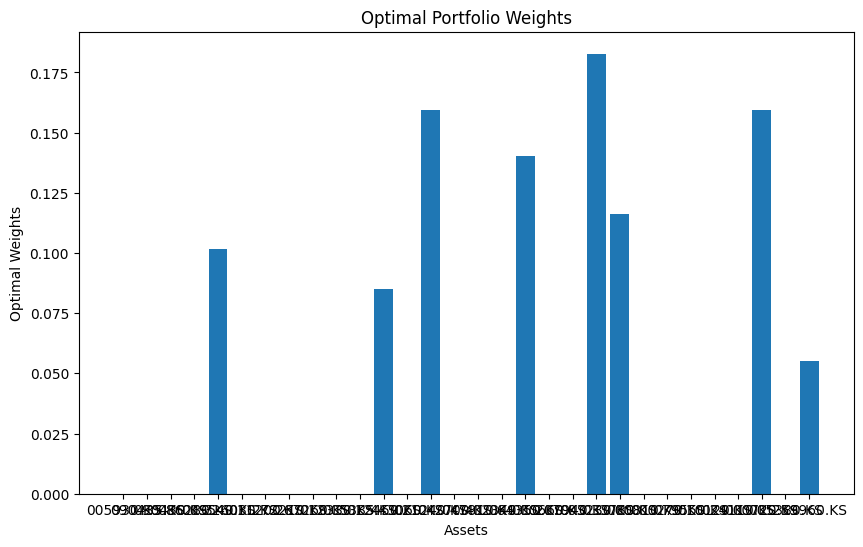

In [20]:
plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()